# Test new function to add arbitrary LH modulation

In [1]:
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles
import numpy as np
from scipy.interpolate import interp1d
from scipy.special import jv as besselj  # Using jv for Bessel function
import matplotlib.pyplot as plt

In [2]:
def addLHmodulationGeneral(inputBeam, Elaser, PowerProfile=None, tvector=None, case='Gaussian', sigmat_laser=None, offset=None, showplots=False):
    # Hardcode FACET-II laser and undulator parameters
    lambda_laser = 760e-9
    sigmar_laser = 200e-6
    K = 1.1699
    lambdaw = 0.054
    Nwig = 9
    
    # Electron beam calculations
    x = inputBeam.x - np.mean(inputBeam.x)
    y = inputBeam.y - np.mean(inputBeam.y)
    t = inputBeam.t-np.mean(inputBeam.t);
    gamma = inputBeam.gamma
    gamma0 = np.nanmean(inputBeam.gamma)     

    if gamma0 == 0 or np.isnan(gamma0):
        print("Warning: gamma0 is either zero or NaN. Returning None.")
        return None    

    # Calculated parameters for arbitrary case
    lambda_r = lambdaw / (2 * gamma0**2) * (1 + K**2 / 2)
    omega = 2 * np.pi * 299792458 / lambda_r
    JJ = besselj(0, K**2 / (4 + 2 * K**2)) - besselj(1, K**2 / (4 + 2 * K**2))

    if case == 'arbitrary':
        if PowerProfile is None or tvector is None:
            raise ValueError("For 'arbitrary' case, both PowerProfile and tvector must be provided.")
        
        # Calculate the laser power profile normalized
        PlaserPeak = np.max(PowerProfile)
        normalizedPowerProfile = PowerProfile / PlaserPeak

        # Laser parameters    
        mod_amplitude = np.sqrt(PlaserPeak / 8.7e9) * K * lambdaw * Nwig / gamma0 / sigmar_laser * JJ

        if np.isnan(mod_amplitude):
            print("NaN value in LH mod_amplitude.")
            return None

        # Interpolate Power value at the location of the particle t
        interpolation_function = interp1d(tvector, normalizedPowerProfile, kind='linear', fill_value='extrapolate')
        PlaserInterp = interpolation_function(t)
        
        if np.any(np.isnan(PlaserInterp)):
            print("NaN values found in PlaserInterp.")
            return None

        if showplots:
            plt.scatter(t, PlaserInterp)
            plt.title("Interpolated Laser Power")
            plt.xlabel("Time")
            plt.ylabel("Normalized Laser Power")
            plt.show()

        # Calculate induced modulation for arbitrary case - Laser is assumed transversely Gaussian 
        deltagamma = mod_amplitude * np.sqrt(PlaserInterp) * \
                     np.exp(-0.25 * (x**2 + y**2) / sigmar_laser**2) * np.sin(omega * t)
        deltapz = deltagamma / gamma0

    elif case == 'Gaussian':
        # Set default values if not provided
        if sigmat_laser is None:
            sigmat_laser = (6 / 2.355) * 1e-12  # Default value for sigmat_laser
        if offset is None:
            offset = 0.0  # Default value for offset

        Plaser = Elaser / np.sqrt(2 * np.pi * sigmat_laser**2)
        
        # Laser is assumed transversely Gaussian with peak power Plaser
        mod_amplitude = np.sqrt(Plaser / 8.7e9) * K * lambdaw * Nwig / gamma0 / sigmar_laser * JJ
        
        # Calculate induced modulation for Gaussian case
        deltagamma = mod_amplitude * np.exp(-0.25 * (x**2 + y**2) / sigmar_laser**2) * \
                     np.sin(omega * t ) * \
                     np.exp(-0.25 * ((t - offset ) / sigmat_laser)**2)

    else:
        raise ValueError("Invalid case provided. Use 'arbitrary' or 'Gaussian'.")

    # Update the outputBeam with the new gamma values
    outputBeam = inputBeam.copy()
    outputBeam.gamma = inputBeam.gamma + deltagamma
    
    return outputBeam, deltagamma, t

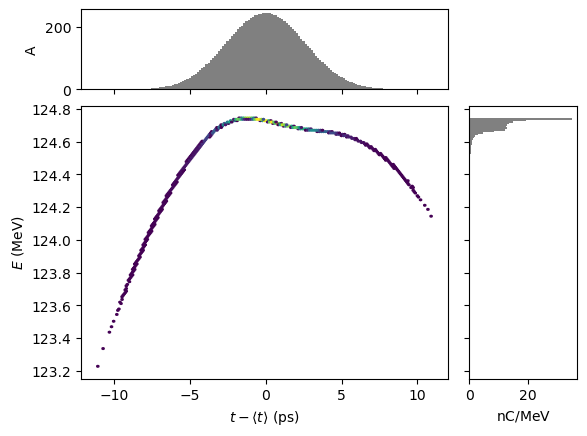

In [3]:
# Load the beam at HTRUNDF in Particle Group format
inputBeam = ParticleGroup('beamAtHTRUNDFpreLH.h5')
inputBeam.plot('delta_t','energy');

# Ex 1 - arbitrary laser power profile

0.0004999999999999999


/var/folders/8q/6b4y6s2j6k1c3xx0g7509t192wsclr/T/ipykernel_81158/2405489280.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_energy = np.abs(np.trapz(tvector,Pvector))
/var/folders/8q/6b4y6s2j6k1c3xx0g7509t192wsclr/T/ipykernel_81158/2405489280.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(np.abs(np.trapz(tvector,Pvector)))


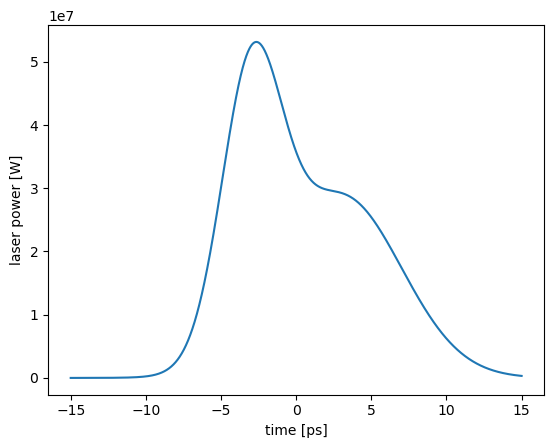

In [4]:
# Define an arbitrary laser power profile - e.g. sum of 2 Gaussians w different sigmas and offsets
Elaser = 0.5e-3;
tvector = np.linspace(-15e-12,15e-12,10000);
sigmat_laser1 = 2e-12;
sigmat_laser2 = 4e-12;
offset1 = -3e-12;
offset2 = 3e-12;
amp1 = 1.5;
amp2 = 1;
Pvector = amp1*np.exp(-0.5*((tvector - offset1) / sigmat_laser1)**2) +  amp2*np.exp(-0.5*((tvector - offset2) / sigmat_laser2)**2)
total_energy = np.abs(np.trapz(tvector,Pvector)) 
Pvector = Pvector*(Elaser/total_energy)# Normalize to the total laser energy
print(np.abs(np.trapz(tvector,Pvector)))
plt.plot(tvector*1e12,Pvector);plt.xlabel('time [ps]');plt.ylabel('laser power [W]')
plt.show()

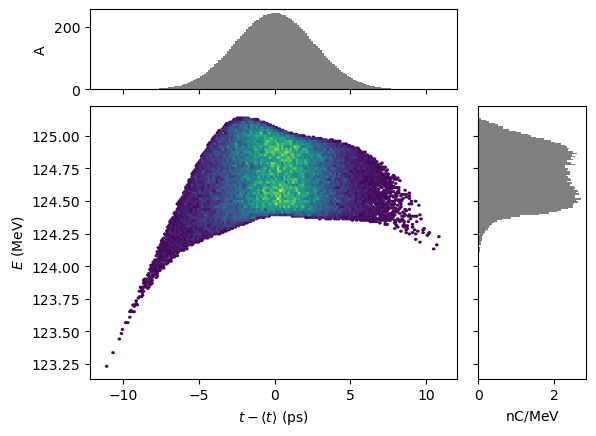

In [5]:
# Call the function to add the LH modulation
beamAfterLHmodulation, deltagamma, t = addLHmodulationGeneral(
    inputBeam, 
    Elaser,
    PowerProfile=Pvector,  # Use this for 'arbitrary' case
    tvector=tvector,            # Use this for 'arbitrary' case
    case='arbitrary',
    showplots=False              # Set to True if you want to see plots
)
beamAfterLHmodulation.plot('delta_t','energy');

# Ex 2 - Gaussian with given energy, sigmat and offset

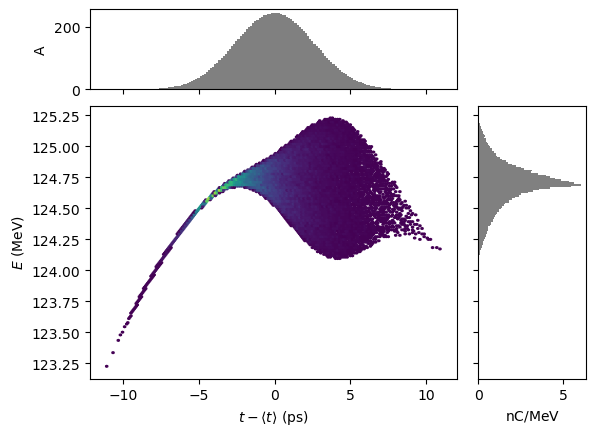

In [6]:
# Call the function to add the LH modulation
beamAfterLHmodulation, deltagamma, t = addLHmodulationGeneral(
    inputBeam, 
    Elaser,
    case='Gaussian',
    sigmat_laser=2e-12,  # Optional, only for Gaussian case
    offset=4e-12, 
    showplots=False      # Set to True if you want to see plots
)
beamAfterLHmodulation.plot('delta_t','energy');

# Ex 3 - Default with user specifying only laser energy

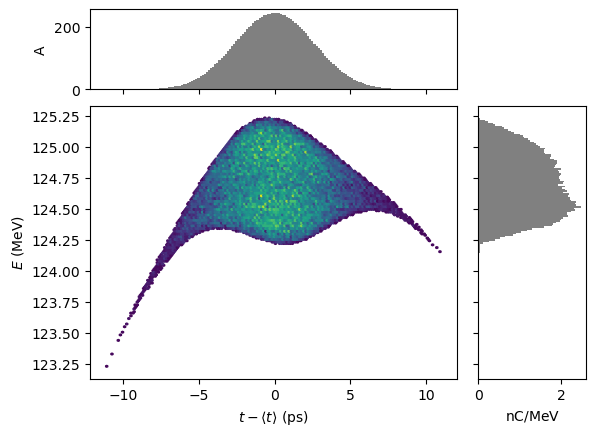

In [7]:
# Call the function specifying only the LH energy (defaults to Gaussian with 6ps FWHM and 0 offset).
beamAfterLHmodulation, deltagamma, t = addLHmodulationGeneral(
    inputBeam, 
    Elaser,    
    showplots=False      # Set to True if you want to see plots
)
beamAfterLHmodulation.plot('delta_t','energy');

In [8]:
# # Convert from openPMD to bmad and save output beam
# Pdict=bmad_to_OpenPMD('beamAtHTRUNDFpreLH.h5')# You can do the LH manipulation on the particle group data but you need to read the time offset from the bmad file that you dump at HTRUNDF
# OpenPMD_to_Bmad('beamAfterLHmodulation.h5',Pdict['timeOffset'])